# Exploring the forcing used for the f6 forecast and c5 control runs
Note that the longnames of the f6 forecasts follow c5-d60-pX-f6-INIT (where INIT is the initialisation date) indicating that c5 is the relevant control run for these forecasts.

All (resonable sized) files used in this notebook are copied in the /resources directory in this repo.

In [88]:
import glob
import numpy as np
import xarray as xr
from distributed import Client
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster

import warnings
warnings.filterwarnings("ignore")

### Cluster only needed for examining actual control and forecast data, not for looking at forcing files

In [124]:
walltime = '01:00:00'
cores = 12
memory = '24GB'

cluster = PBSCluster(processes=1,
                     walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P ux06',
                                '-l jobfs=100GB',
                                '-l storage=gdata/xv83+gdata/v14+gdata/v19+scratch/v14'],
                     local_directory='$PBS_JOBFS',
                     header_skip=['select'])

In [125]:
cluster.scale(jobs=6)
client = Client(cluster)
client

Client Scheduler: tcp://10.6.67.72:40513 Dashboard: http://10.6.67.72:43237/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
def read_gblannualdata(file_name):
    with open(file_name, 'r') as data:
        next(data)
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return xr.DataArray(y, dims=('year'), coords={'year': x})

# Control run 5

Matt Chamberlain's readme (`/resources/g.data.v19.mtc599.ao_am2.readme.txt`) identifies his run /aug18a as c5:

   > aug18a/ \
(control-5 => control-4 with deep restoring)
clone of the control may18b/ but with deep restoring.
Hiccup with CFC fixed at start of year 0244; CFC tracer field had been reset at year 0200, however the atmospheric boundary condition was not set to the century 0200 to 0299.
At 0244, reset tracer fields to zero and fix boundary condition.
(Control 5)

We can get an idea for how this control run was forced by looking at select lines in the namelist (`/resources/g.data.v19.mtc599.ao_am2.aug18a.input.nml`):

That is, 1990 forcing is used for a variety of aerosol, ozone, solar, and radiative gas forcings. No volcanic forcing is applied

## What do these forcing files look like?

### aerosol.climatology.nc 
\> climatologies of aerosol concentrations for each decade \
\> max decade 2010

In [8]:
path = '/g/data/v19/mtc599/ao_am2/aug18a/'

f = xr.open_dataset(f'{path}INPUT/aerosol.climatology.nc')

In [9]:
f

<xarray.Dataset>
Dimensions:           (lat: 80, latb: 81, lon: 96, lonb: 97, sigma_full: 14, sigma_half: 15, time: 204)
Coordinates:
  * lon               (lon) float32 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
  * lonb              (lonb) float32 -1.875 1.875 5.625 ... 350.6 354.4 358.1
  * lat               (lat) float32 -88.29 -86.07 -83.84 ... 83.84 86.07 88.29
  * latb              (latb) float32 -90.0 -87.18 -84.96 ... 84.96 87.18 90.0
  * sigma_full        (sigma_full) float32 0.015 0.05035 ... 0.9786 0.9966
  * sigma_half        (sigma_half) float32 0.0 0.03 0.0707 ... 0.964 0.9933 1.0
  * time              (time) object 1859-01-16 00:00:00 ... 2010-12-16 00:00:00
Data variables: (12/21)
    so4_anthro        (time, sigma_full, lat, lon) float32 ...
    so4_natural       (time, sigma_full, lat, lon) float32 ...
    organic_carbon    (time, sigma_full, lat, lon) float32 ...
    black_carbon      (time, sigma_full, lat, lon) float32 ...
    sea_salt          (time, sigma_full, lat, lon) float32 ...
    anthro_dust_0.1   (time, sigma_full, lat, lon) float32 ...
    ...                ...
    natural_dust_0.4  (time, sigma_full, lat, lon) float32 ...
    natural_dust_0.8  (time, sigma_full, lat, lon) float32 ...
    natural_dust_1.0  (time, sigma_full, lat, lon) float32 ...
    natural_dust_2.0  (time, sigma_full, lat, lon) float32 ...
    natural_dust_4.0  (time, sigma_full, lat, lon) float32 ...
    natural_dust_8.0  (time, sigma_full, lat, lon) float32 ...
Attributes:
    title:        Monthly mean aerosol distributions for use in FMS AM models
    authors:      Stuart Freidenreich (smf@gfdl.noaa.gov): Compilation of dat...
    institution:  GFDL/NOAA
    history:      Tue Aug 17 15:26:36 2004: ncks -v time -A /net/lwh/fms/aero...

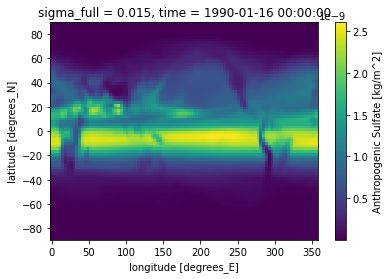

In [10]:
f['so4_anthro'].sel(time='1990-01').isel(sigma_full=0).plot()

### o3.climatology.nc
\> monthly values of ozone mass mixing ratio (decadal frequency prior to 1980) \
\> max year 2004

In [11]:
f = xr.open_dataset(f'{path}INPUT/o3.climatology.nc')

In [12]:
f['ozone']

<xarray.DataArray 'ozone' (time: 468, pfull: 40, lat: 60, lon: 100)>
[112320000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 1.8 5.4 9.0 12.6 16.2 ... 347.4 351.0 354.6 358.2
  * lat      (lat) float32 -88.5 -85.5 -82.5 -79.5 -76.5 ... 79.5 82.5 85.5 88.5
  * pfull    (pfull) float32 0.00957 0.03083 0.06967 ... 922.2 972.9 1.004e+03
  * time     (time) object 1859-01-16 00:00:00 ... 2004-12-16 00:00:00
Attributes:
    units:      kg/kg
    long_name:  ozone mass mixing ratio

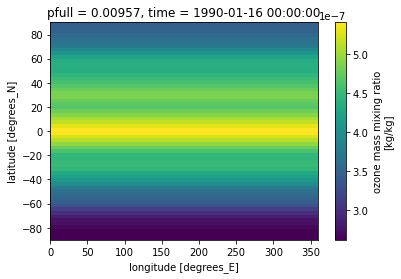

In [13]:
f['ozone'].sel(time='1990-01').isel(pfull=0).plot()

### radiative gases
It's not clear from the namelist what files are used for these forcings. I _think_ the model must use the following files from the /INPUT directory:
   > ch4_gblannualdata \
   co2_gblannualdata \
   f113_gblannualdata \
   f11_gblannualdata \
   f12_gblannualdata \
   f22_gblannualdata \
   n2o_gblannualdata

\> annual global-average timeseries \
\> max year 2004

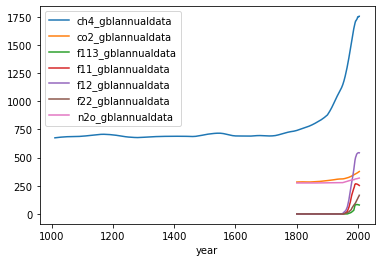

In [14]:
files = ['ch4_gblannualdata', 'co2_gblannualdata', 'f113_gblannualdata', 'f11_gblannualdata', 
         'f12_gblannualdata', 'f22_gblannualdata', 'n2o_gblannualdata']
for file in files:
    f = read_gblannualdata(f'{path}INPUT/{file}')
    f.plot()
plt.legend(files)

## So what does the c5 data look like?

### E.g. global average sst
Note, the format of the files changes in the year 0100 (`grid_xt_ocean`, `grid_yu_ocean`, `potrho`, `potrho_edges` are added as coordinates) and 0300 (many more variables added) and xarray struggles with automatically merging these periods. Do this manually.

In [126]:
files = sorted(glob.glob(f'{path}OUTPUT/ocean_month*.nc'))
kwargs = dict(
    concat_dim='time',
    chunks={'time': 48},
    compat='override',
    coords='minimal',
    data_vars='minimal',
    parallel=True)

om1 = xr.open_mfdataset(
    files[:99],
    **kwargs)

om2 = xr.open_mfdataset(
    files[99:299],
    **kwargs)

om3 = xr.open_mfdataset(
    files[299:],
    **kwargs)

In [127]:
%%time
sst = xr.concat([
    om1['temp'].sel(st_ocean=5.0),
    om2['temp'].sel(st_ocean=5.0),
    om3['temp'].sel(st_ocean=5.0)],
    dim='time')
area_t = om3['area_t']

sst_gbl = sst.weighted(area_t).mean(['xt_ocean','yt_ocean']).compute()

CPU times: user 11.9 s, sys: 1.25 s, total: 13.2 s
Wall time: 24.5 s


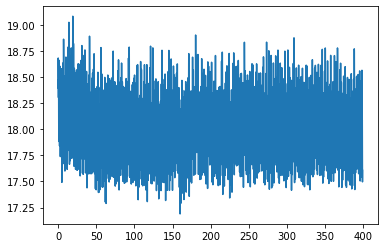

In [128]:
plt.plot(np.arange(len(sst_gbl)) / 12, sst_gbl)

### So, given the comment in the readme copied above, c5 provides 155 years (years 244-399) of apparently stable control run with 1990(s) forcing

# Forecast 6

The relevant lines in the f6 namelist are as follows (`/resources/g.data.v14.ds0092.active_projects.cm-forecasts.ref.MODEL.input.in`):

where the following replacements are made before submission:

 - Replace
   ```
       INPUT_AEROSOL_TIME -> "AYEAR, 1, 1, 0, 0, 0"
   ```
   where AYEAR is the middle year of the decade in which the forecast is initialised (e.g. AYEAR=2005 for any
   start date in the 2000s).
   
 - If the forecast is initialised after 2000 then replace,
   ```
       REPEAT_VOLCANO_YEAR -> "repeat_volcano_year=.true."
       VOLCANO_YEAR_USED -> "volcano_year_used = 2008,"
   ```
   otherwise these lines are commented out.
   
- If the forecast is initialised after 2004 then replace,
   ```
       BASIC_OZONE_TYPE -> "fixed_year"
       OZONE_DATASET_ENTRY -> "ozone_dataset_entry=2014, 1, 1, 0, 0, 0,"
       FILENAME -> "cm3_2014_o3.padded.nc"
   ```
   otherwise replace,
   ```
       BASIC_OZONE_TYPE -> "time_varying"
       FILENAME -> "CM3_CMIP6_1950-2014_O3.nc"
   ```
   and OZONE_DATASET_ENTRY is commented out.
   
As above, I'm not 100%

If the forecast is initialised after 2000 then,
    REPEAT_VOLCANO_YEAR -> "repeat_volcano_year=.true."
    VOLCANO_YEAR_USED -> "volcano_year_used = 2008,"
otherwise these lines are commented out. That is, time varying volcanic forcing is used for forecasts initialised prior to or during 2000, and 2008 volcanic forcing is used for those initialised after 2000. I can't make any sense of the volcanic forcing files extsw_data.nc, omgsw_data.nc, asmsw_data.nc so I just have to trust that they are what they're supposed to be.

# Ozone:
--------
If the forecast is initialised after 2004 then,
    BASIC_OZONE_TYPE -> "fixed_year"
    OZONE_DATASET_ENTRY -> "ozone_dataset_entry=2014, 1, 1, 0, 0, 0,"
    FILENAME -> "cm3_2014_o3.padded.nc"
else,
    BASIC_OZONE_TYPE -> "time_varying"
    FILENAME -> "CM3_CMIP6_1950-2014_O3.nc"
and the OZONE_DATASET_ENTRY is commented out. That is, time varying ozone forcing is used for forecasts initialised prior to or during 2004, and 2014 ozone forcing is used for those initialised after 2004. Both cm3_2014_o3.padded.nc and CM3_CMIP6_1950-2014_O3.nc are monthly frequency with dimensions lat, lon and pfull.

# Radiative gases:
------------------
It's not 100% clear to me how the model knows which files to use here. There are radiative gas forcing files in the INPUT directory like co2_gblannualdata (same for the other gases listed above) which I assume are being used. These are just text files containing values for each year between 1800 and 2110. It's not immediately clear to me which scenario is used for future values, though the CMIP5 docs ask for RCP4.5.
There's also a separate part of the run scripts where the following is added to the field_table:
    aco2_file = ACO2_FILE
where ACO2_FILE="INPUT/co2_obs.padded.nc" if the forecast is initialised after 2007, otherwise ACO2_FILE="INPUT/co2_obs.nc". Both files have dimensions grid_y_T and grid_x_T but are constant across these dimensions (i.e. not spatially varying). co2_obs.padded.nc includes projected values into the future. In fact, these files are identical in their overlapping period so the switch from co2_obs.nc to co2_obs.padded.nc seems to be completely redundant. I'm not sure how these co2 files interact with co2_gblannualdata or why both are needed.  I think the co2_obs* files are for the bgc component. I'll try to confirm this with Matt.